##  Digital Quantum Simulations of Time Evolution - Simulating the Dicke Model
---
### Modules and some comments
Take a look at the file `classical_evolution` in the folder `tools`.

In [1]:
# Ignore: things to make plots pretty on my computer 
from pkg_resources import working_set

if 'jupyterthemes' in ["%s" % package.key for package in working_set]:
    from jupyterthemes import jtplot
    jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = True)

In [2]:
# Important: the functions below are defined in the files `classical_evolution` and 
# `quantum_evolution` in the folder `tools`
from tools.classical_evolution import dicke_hamiltonian, state_probability, define_state
from tools.quantum_evolution import get_circuit, trotter_circuit, define_operator

In [12]:
# Usual suspects
from numpy import linspace, pi, zeros_like, zeros, ones
from qiskit import Aer
from qiskit.opflow import CircuitSampler, StateFn, I, Z
from qiskit.opflow.expectations import PauliExpectation
from matplotlib.pyplot import plot, xlabel, ylabel, title, grid, show, legend, ylim

### Classical simulation
It is already generalizable to $N>2$ and, hoping that it is more or less correct, you can already try to see what happens by changing the `spins` variable.

In [32]:
# Checking if the hamiltonian is correct
spins = 2 # Number of 2-level systems
coupling = 2
hamiltonian = dicke_hamiltonian(spins = spins, frequency = 1, coupling = coupling)
print(hamiltonian)

1.0 * IZ
+ 1.0 * ZI
- 4.0 * XX


In [33]:
# Classical simulation
times = linspace(0, pi, 200) # Time discretization
initial_state = define_state([0 for _ in range(spins)]) # Ground state: all spins down
state = define_state([1 for _ in range(spins)]) # All spins up
classical_probabilities = [state_probability(hamiltonian, time, initial_state, state) for time in times]

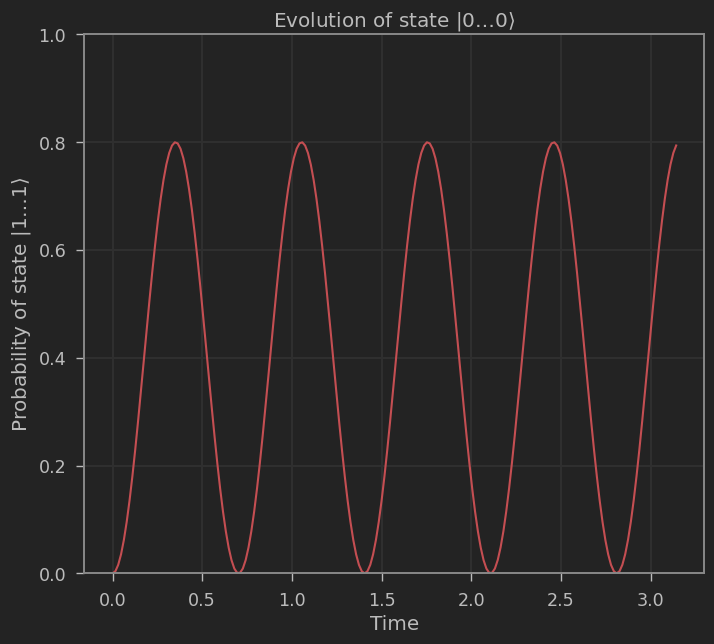

In [34]:
plot(times, classical_probabilities, '-r')
xlabel('Time')
ylim(0, 1)
ylabel(r'Probability of state $|1\dots1\rangle$')
title(r'Evolution of state $|0\dots0\rangle$')
show()

### Quantum simulation
First notice that:

$$H^{(2)}=\omega_z\left(\sigma_z^{(1)}+\sigma_z^{(2)}\right)-2g\sigma_x^{(1)}\sigma_x^{(2)}$$

now, we have that:

$$
\begin{cases}
\left[\sigma_z^{(1)}, \sigma_z^{(1)}\right]=0 \\
\left[\sigma_z^{(1)}, \sigma_x^{(1)}\sigma_x^{(2)}\right]=\left[\sigma_z^{(1)}, \sigma_x^{(1)}\right]\sigma_x^{(2)}=-2\mathcal{i}\sigma_y^{(1)}\sigma_x^{(2)} \\
\left[\sigma_z^{(2)}, \sigma_x^{(1)}\sigma_x^{(2)}\right]=\dots=-2\mathcal{i}\sigma_y^{(2)}\sigma_x^{(1)} \\
\end{cases}
$$

thus they do not commute even in this case, so we have to use the Trotter-Suzuki technique.

By the way, it should work with whatever number $N$, also for $N>2$.

**Question**: why we use the same $n$ for all the time instants in the implementation of the Trotter-Suzuki technique?

In [35]:
backend = Aer.get_backend("statevector_simulator")
expectation = PauliExpectation() 
sampler = CircuitSampler(backend)

In [36]:
steps = [4, 8, 12]
quantum_probabilities = {i : zeros_like(times) for i in steps}
operator = define_operator([1 for _ in range(spins)])

In [37]:
for steps in quantum_probabilities.keys():
    for i, time in enumerate(times):
        circuit = trotter_circuit(spins, time, steps, coupling)
        trotter_expectation = expectation.convert(operator @ StateFn(circuit))
        trotter_sample = sampler.convert(trotter_expectation)
        quantum_probabilities[steps][i] = trotter_sample.eval().real

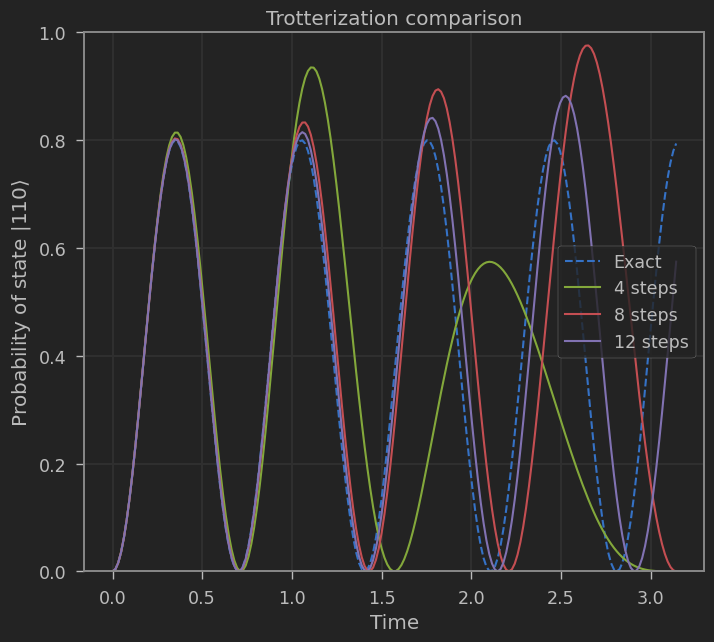

In [38]:
plot(times, classical_probabilities, '--', label = "Exact")

for steps in quantum_probabilities.keys():
    plot(times, quantum_probabilities[steps], label = str(steps) + " steps")

xlabel('Time')
ylabel(r'Probability of state $|110\rangle$')
title(r'Trotterization comparison')
ylim(0, 1)
legend()
show()